# Simulation: Number of collisions for ENUM-Based Regular ISD

This code applies ENUM-Based Regular ISD on random RSD instances, to verify the formula on the number of collisions.
Namely, starting from lists $L_1$ and $L_2$ with respective sizes $|L_1|$ and $|L_2|$, we estimate the average number of collisions as 

$$\frac{|L_1|\cdot |L_2|}{2^\ell}$$

Remember that the lists may have (slightly) different sizes, due to the fact that for a practical implementation of the algorithm, we have to deal with rounding issues.

The code considers several parameters, which can be chosen by the user.
Two regimes are considered:
- code rate $R > 1 - \frac{1}{e\ln(2)}$: in this case, we compute the largest w for which we have a unique solution
- code rate $R < 1 - \frac{1}{e\ln(2)}$: in this case, we consider several values of $w$

For each of these instances, we consider the values of $p$ and $\ell$ which optimize the algorithm (i.e., give the lowest time complexity).

In [117]:
reset(); 

load("PGE.sage"); #required to perform Partial Gaussian Elimination
load("list_ops.sage"); #required to merge lists

#On input an initial value for n (n_in) and code rate R, computes w
#using the uniqueness bound
def RSD_params_uniqueness_bound(n_in, R):

    n = n_in
    k = round(R*n)
    
    #compute max value of w
    b = n
    while (b**(n/b))<(2**(n-k)):
        b = b - 1
    b = b + 1
    
    #adjust parameters so that b divides n
    n = b*floor(n/b)
    k = floor(n*R)
    w = n/b
        
    return n, k, w, b

############################################################
#Generate random RSD instance (requires that n is divided by b)
def sample_rsdp_instance(n,k,b,w):

    F2 = GF(2);

    #Sample full rank parity-check matrix
    rank_H = 0;
    while rank_H < (n-k):
        H = random_matrix(F2,n-k,n);
        rank_H = rank(H);

    #Sample regular error vector
    e = matrix(F2,1,n);
    for i in range(w):
        pos = randrange(b);
        e[0,i*b+pos] = F2(1);

    #Compute syndrome
    s = H*e.transpose();

    return H, e, s;

##############################################

#Include the additional parity-check equations
def add_parity_checks(H, s, n, k, b, w):

    #Compute adapted parameters
    r = n - k;
    rp = n - k + w;
    kp = n - rp;

    ##Modify H: add partiy-check equations, remove last columns
    new_H = matrix(GF(2),rp,n);
    new_H[0:r, :] = H;
    for i in range(w):
        for j in range(b):
            new_H[r+i,i*b+j] = 1;

    new_H = new_H[:,0:n];

    ##Modify s: add new bits, corresponding to new parity-check equations
    new_s = matrix(GF(2), rp, 1);
    new_s[0:r, 0] = s;
    for i in range(w):
        new_s[r+i,0] = 1;

    return new_H, new_s;

# Theoretical estimates and implementation of ENUM-Based regular ISD
Returns the parameters to optimize the attack, as well internal quantities which will be later estimated with the simulations.

The implementation of the ENUM-Based regular ISD is the same as in the sim_EnumBased.ipynb notebook (check the notebook for a description of the code)

In [118]:
#Concrete cost estimate for enumeration based ISD
#It outputs the parameters that optimize the attack, together with internal quantities:
#- parameters p and ell
#- success probability of one iteration
#- list size and number of collisions

#Input:
#- (n, k, w, b): RSD parameters, with:
#  - n: code length
#  - k: code dimension
#  - w: Hamming weight of solution
#  - b: size of weight-1 blocks
#- S: expected number of existing solutions

def enumeration_based_concrete_cost_rounding(n,k,w,b, S):


    k_prime = k-w;  #add parity-checks

    min_cost = 1000000000000000000000000000000;
    best_params = [];


    p_max = 30;
    ell_max = 30
    
    for p in range(0,min(p_max, floor(w/2))+1,2):
        for ell in range(0, min(ell_max, n-k_prime)+1):
            
            
            v = floor((k_prime+ell)/w)
                        
            if (v+1)>b:
                continue;
            
            w_minus = w*(v+1)-k_prime-ell; w_plus = w-w_minus
            
            w1_minus = floor(w_minus/2)
            w2_minus = ceil(w_minus/2)
            
            w1_plus = ceil(w_plus/2)
            w2_plus = floor(w_plus/2)
            
            pr1 = 0; L1 = 0
            for i in range(max(0, floor(p/2)-w1_plus),min(floor(p/2),w1_minus)+1):
                term = binomial(w1_minus,i)*(1-v/b)**(w1_minus-i)*(v/b)**i*binomial(w1_plus,p/2-i)*(1-(v+1)/b)**(w1_plus-(p/2-i))*((v+1)/b)**(p/2-i)
                pr1+=term;
                L1 += binomial(w1_minus,i)*binomial(w1_plus,p/2-i)*v**i*(v+1)**(p/2-i)
                
                
            pr2 = 0; L2 = 0
            for i in range(max(0, floor(p/2)-w2_plus),min(floor(p/2),w2_minus)+1):
                term = binomial(w2_minus,i)*(1-v/b)**(w2_minus-i)*(v/b)**i*binomial(w2_plus,p/2-i)*(1-(v+1)/b)**(w2_plus-(p/2-i))*((v+1)/b)**(p/2-i)
                pr2+=term;
                L2 += binomial(w2_minus,i)*binomial(w2_plus,p/2-i)*v**i*(v+1)**(p/2-i)

            num_coll = L1*L2*2**(-ell);

            T_iter = n*(n-k_prime)**2+n*(L1+L2+num_coll);
            p_iter = pr1*pr2*S; #taking into account multiple solutions
            
            if p_iter <= 0:
                continue;
                
            cost = log(T_iter, 2)-log(p_iter, 2);
            
            #update min cost  if new cost is smaller
            if cost<min_cost:
                min_cost = N(cost);
                best_params = [p, ell, w1_minus, w1_plus, w2_minus, w2_plus, v, v+1]
                quantities = [log(L1, 2), log(L2, 2), log(num_coll, 2), log(p_iter, 2)]
                
    return min_cost, best_params, quantities

Implementation of main algorithm and subroutines

In [119]:
#Enumerate regular vectors for initial lists
def all_regular_initial_list(p_half, w_f, v_f, w_c, v_c):
    
    vec_length = w_f*v_f+w_c*v_c; #length of the vectors we are going to enumerate
    
    all_vecs = [];
    
    #we consider i_f blocks with length v_f and weight 1, i_c = p_half - i_f blocks with length v_c and weight 1
    for i_f in range(p_half + 1):
        
        i_c = p_half - i_f;
        
        pos_v_f = cartesian_product([range(v_f) for i in range(i_f)]);
        pos_v_c = cartesian_product([range(v_c) for i in range(i_c)]);
        
        pos_unit_vectors_f = Combinations(w_f, i_f);
        pos_unit_vectors_c = Combinations(w_c, i_c);
        
        for pos_f in pos_unit_vectors_f:
            for pos_c in pos_unit_vectors_c:
                for pos_ones_f in pos_v_f:
                    for pos_ones_c in pos_v_c:
                        candidate = matrix(GF(2),1, vec_length);
                        
                        for j in range(len(pos_f)):
                            this_pos = pos_f[j]*v_f+pos_ones_f[j];
                            candidate[0, this_pos] = 1;
                        for j in range(len(pos_c)):
                            this_pos = w_f*v_f+v_c*pos_c[j]+pos_ones_c[j];
                            candidate[0, this_pos] = 1;
                            
                        all_vecs.append(candidate);
    
    return all_vecs;

######################################

#Create initial lists: takes as input the sub-parity check matrix and the list of vectors, 
#together with target syndrome and coeff_val (either 0 or 1)
def create_list_partial_sums(H_sub, list_vectors, target_s):

    list_sums = [];
    for x in list_vectors:
        s = target_s + x*H_sub.transpose();
        list_sums.append(s);

    return list_sums;
#######################################################

#Find collisions and return list of (merged) vectors
def merge_lists(list_sums_left, list_sums_right, all_vecs_left, all_vecs_right):
    
        
    indexes = colliding_indexes(list_sums_left, list_sums_right);    

    new_list_vectors = [];
    for i in range(len(indexes)):

        new_vector = block_matrix(GF(2),1,2,[all_vecs_left[indexes[i][0]], all_vecs_right[indexes[i][1]]]);
        new_list_vectors.append(new_vector);
    
    return new_list_vectors;


###################################################
#Sample regular permutation 
def ENUM_sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right):
    
   # print(v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right);
    P_list_left = sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, 0);
    P_list_right = sample_regular_permutation(n, b, v_f, v_c, w_f_right, w_c_right, b*(w_f_left + w_c_left));
    
    for i in P_list_right:
        P_list_left.append(i);
    
    
    #Now, place the remaining coordinates (i.e., those that will be move to the last n-k' positions)
    for i in range(n):
        if i not in P_list_left:
            P_list_left.append(i);
    
    #Create permutation matrix out of P
    P = matrix(GF(2),n,n);
    for i in range(n):
        P[P_list_left[i], i] = 1;
    

    return P;

##################################################

#Sample regular permutation
#Sample v_f coordinates from w_f blocks, v_c coordinates from w_c blocks and move them in first positions;
#These coordinates will constitute the information set
def sample_regular_permutation(n, b, v_f, v_c, w_f, w_c, offset):
    
    P_list = []; #regular permutation
    
    #We first sample coordinates for the w_f blocks (v_f from each block)
    for i in range(w_f):
        
        perm_of_b = Permutations(range(b)).random_element();
        for j in range(v_f):
            P_list.append(i*b+perm_of_b[j]+offset);
    
    #Now, sample coordinates for the w_c blocks (v_c from each block)
    for i in range(w_c):
        perm_of_b = Permutations(range(b)).random_element();
        for j in range(v_c):
            P_list.append((w_f+i)*b+perm_of_b[j]+offset);
    
    return P_list;

######################

#Checks if input vector is regular
def check_regularity(x,b):
    n = x.ncols();
    
    is_regular = 1;
    for i in range(w):
        num_ones_in_block = x[0,i*b:(i+1)*b].list().count(1);
        if num_ones_in_block != 1:
            is_regular = 0;

    return is_regular;

In [120]:
######################
#ENUM-based ISD; it receives as input the H with additional equations
#It also updates the empirical estimates (last three parameters)
#It also requires the list of vectors to prepare the initial lists
#params must be formatted as [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v_f, v_c]
def ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll):
    
    p = params[0]; ell = params[1]; 
    w_f_left = params[2]; w_c_left = params[3]; w_f_right = params[4]; w_c_right = params[5]; 
    v_f = params[6]; v_c = params[7];
    
    ok = 0; #ok becomes 1 when a solution is found

    #Sample regular permutation
    P = ENUM_sample_regular_permutation(n, b, v_f, v_c, w_f_left, w_c_left, w_f_right, w_c_right);

    #Apply permutation to H
    perm_H = new_H*P;
    
    #Do PGE, continue only if PGE does not fail
    is_full_rank, reduced_H, reduced_s = PGE(n, n-k_prime, ell, perm_H, new_s);
    
    if is_full_rank:

        num_PGE_ok += 1;

        #create first list
        list_sums_left = create_list_partial_sums(reduced_H[0:ell,0:w_f_left*v_f+w_c_left*v_c], all_vecs_left, matrix(GF(2),1,ell));
        
        #create second list
        list_sums_right = create_list_partial_sums(reduced_H[0:ell,w_f_left*v_f+w_c_left*v_c:k-w+ell], all_vecs_right, reduced_s[0:ell].transpose());
        
        #find collisions and merge vectors
        merged_vecs = merge_lists(list_sums_left, list_sums_right, all_vecs_left, all_vecs_right);
        
        #Update max, min and average num collisions
        avg_num_coll += len(merged_vecs); #update estimate on average number of collisions
        max_num_coll = max(log(len(merged_vecs),2), max_num_coll)
        min_num_coll = min(log(len(merged_vecs),2), min_num_coll)
        
        ok_found = 0;
        for x in merged_vecs:
            H_sub = reduced_H[ell:,0:k_prime+ell];
            x_right = reduced_s[ell:] - H_sub*x.transpose();
            
            w_x = x_right.list().count(1);
            if w_x == w - p: #the vector has the right weight, continue by check
                
                perm_candidate_e = block_matrix(GF(2),1,2,[x, x_right.transpose()]);
                candidate_e = perm_candidate_e*P^-1;
                
                is_regular = check_regularity(candidate_e,b);
                if is_regular:
                    ok = 1; 
    
    num_success += ok;
    
    return num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll

# Set simulation

Select the code parameters ($n$, $k$, $b$ and $w$) and the number of RSD instances to be generated (denoted by $\mathtt{num}\_\mathtt{instances}$)

We consider only values of the code rate $R$ such that $R>1-\frac{1}{e\ln(2)}$

The min and max considered code rates are given by $\mathtt{R}\_\mathtt{int}\_\mathtt{min}/100$ and $\mathtt{R}\_\mathtt{int}\_\mathtt{max}/100$. The step between two consecutive code rates is $\mathtt{R}\_\mathtt{step}/100$

For each considered set of parameters, we consider the highest value of $w$ for which we have an expected unique solution.

In [121]:
seed = 0; #choose seed for simulation
set_random_seed(seed)

R_int_min = 50; R_int_max = 80; R_step = 5; #rate parameters

n_in = 100; #code length
num_instances = 100; #number of RSD instances per each considered rate value

th_vals = []; emp_vals = []; emp_min_vals = []; emp_max_vals = []#values which will be later visualized
rsd_params = []; alg_setting = []

for R_int in range(R_int_min, R_int_max+1, R_step):
    
    #Get RSD parameters
    n, k, w, b = RSD_params_uniqueness_bound(n_in, R_int/100)
    print("Considering: w/n = ",N(w/n+0.),", [n, k, w, b] = "+str([n, k, w, b]));
    
    rsd_params.append((n, k, w, b))
    
    S = max(1, b**w*2**(-(n-k)))#expected number of solutions
    
    k_prime = k-w; #new dimension, due to regularity-encoding equations
    
    if k_prime < 0: #if k_prime < 0, abort simulation
        print("!!! k < w: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        continue;
    
    #Estimate cost of ENUM-Based ISD, optimal setting and theoretical number of collisions
    min_cost, params, quantities = enumeration_based_concrete_cost_rounding(n, k, w, b, S);

    p = params[0]; ell = params[1]; w_f_left = params[2]; w_c_left = params[3]; w_f_right = params[4]; w_c_right = params[5]; v = params[6]
    L1 = quantities[0]; L2 = quantities[1]; num_coll = quantities[2]; p_iter = quantities[3];
    
    alg_setting.append((p, ell))
    
    if p==0: #best algoritm is PERM-based: abort simulation
        print("!!! Optimal p = 0: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        
    #print("Setting: p = "+str(p)+", ell = "+str(ell),", |L1| = 2^"+str(N(L1))+", |L2| = 2^"+str(N(L2)));
    
    #Precompute all regular vectors for lists creation
    all_vecs_left = all_regular_initial_list(p/2, w_f_left, v, w_c_left, v+1);
    all_vecs_right = all_regular_initial_list(p/2, w_f_right, v, w_c_right, v+1);

    #Necessary later, when calling ENUM-based ISD
    params = [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v, v+1]
    
    #Quantities used for simulation
    num_success = 0; #number of successful iterations
    num_full_rank = 0; #num of full rank matrices in ISD
    num_PGE_ok = 0; #number of H' with full ranks
    avg_num_coll = 0; #average number of collisions
    min_num_coll = 100000000000000 #min number of collisions
    max_num_coll = -100000000000000 #min number of collisions
    
    #Generate num_instances random RSD instances
    for id_instance in range(1, num_instances+1):
        
        #Sample RSD instance
        H, e, s = sample_rsdp_instance(n, k, b, w)

        #Add parity-chek equations
        new_H, new_s = add_parity_checks(H, s, n, k, b, w)

        #Launch ENUM-based ISD
        num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll = ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll)
    
    #
    #print("log2(Num_coll): Theoretical: ",N(num_coll))
    #print("Experimental values:");
    #print("log2(Min_num_coll): ",N(min_num_coll),"log2(Avg_num_coll): ",N(log(avg_num_coll/num_PGE_ok,2)),", log2(Max_num_coll): ",N(max_num_coll));
    

    th_vals.append((R_int/100, num_coll))
    emp_vals.append((R_int/100, log(avg_num_coll/num_PGE_ok,2)))
    emp_min_vals.append((R_int/100, min_num_coll))
    emp_max_vals.append((R_int/100, max_num_coll))

Considering: w/n =  0.200000000000000 , [n, k, w, b] = [100, 50, 20, 5]
Considering: w/n =  0.166666666666667 , [n, k, w, b] = [96, 52, 16, 6]
Considering: w/n =  0.125000000000000 , [n, k, w, b] = [96, 57, 12, 8]
Considering: w/n =  0.100000000000000 , [n, k, w, b] = [100, 65, 10, 10]
Considering: w/n =  0.0833333333333333 , [n, k, w, b] = [96, 67, 8, 12]
Considering: w/n =  0.0588235294117647 , [n, k, w, b] = [85, 63, 5, 17]
Considering: w/n =  0.0434782608695652 , [n, k, w, b] = [92, 73, 4, 23]


Plot results in table

In [122]:
from prettytable import PrettyTable 

t = myTable = PrettyTable(["(n, k, w, b)", "(p, ell)","Th. Num Coll.", "EMP Min Num Coll.", "EMP Avg Num. Coll", "EMP Max Num. Coll"]) 
for i in range(len(th_vals)):
    t.add_row([rsd_params[i], alg_setting[i], N(th_vals[i][1]), N(emp_min_vals[i][1]), N(emp_vals[i][1]), N(emp_max_vals[i][1])])

print(t)

+-------------------+----------+------------------+-------------------+-------------------+-------------------+
|    (n, k, w, b)   | (p, ell) |  Th. Num Coll.   | EMP Min Num Coll. | EMP Avg Num. Coll | EMP Max Num. Coll |
+-------------------+----------+------------------+-------------------+-------------------+-------------------+
|  (100, 50, 20, 5) |  (6, 9)  | 10.5793159375800 |  10.4958550268872 |  10.5804847070646 |  10.6510516911789 |
|  (96, 52, 16, 6)  | (6, 10)  | 10.7391946925574 |  10.6220518194564 |  10.7423178580970 |  10.8305152069768 |
|  (96, 57, 12, 8)  |  (4, 7)  | 9.26885264044185 |  9.14210705730255 |  9.27619421140995 |  9.40939093613770 |
| (100, 65, 10, 10) |  (4, 8)  | 9.26091953366291 |  9.13699111208023 |  9.26404375134747 |  9.37068740680722 |
|  (96, 67, 8, 12)  |  (4, 9)  | 8.51644642945345 |  8.24792751344359 |  8.51542388661334 |  8.66888498426625 |
|  (85, 63, 5, 17)  |  (2, 2)  | 7.75488750216347 |  7.53138146051631 |  7.74746329455956 |  8.044394119

Plot values (min and max values are plotted as grey dashed lines)

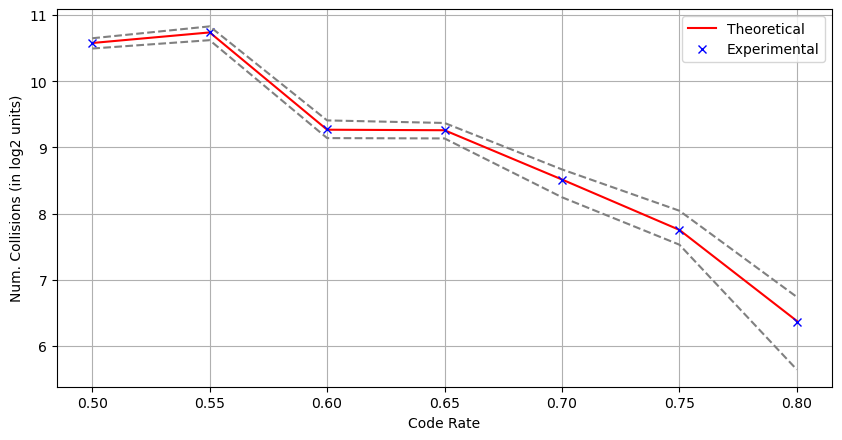

In [123]:
import matplotlib.pyplot as plt

g = plt.figure(figsize=(10, 5), dpi=100)
g = plt.plot([a[0] for a in th_vals],[a[1] for a in th_vals], 'r')
g = plt.plot([a[0] for a in emp_vals],[a[1] for a in emp_vals], 'bx')
g = plt.plot([a[0] for a in emp_min_vals],[a[1] for a in emp_min_vals], 'gray', linestyle = 'dashed')
g = plt.plot([a[0] for a in emp_max_vals],[a[1] for a in emp_max_vals], 'gray', linestyle = 'dashed')

g = plt.legend(['Theoretical', 'Experimental'])
g = plt.grid()
g = plt.xlabel('Code Rate')
g = plt.ylabel('Num. Collisions (in log2 units)')

# Now testing $R < 1-\frac{1}{e\ln(2)}$

We fix the code rate and test several values for $w$. Notice that, in this range, the expected amount of solutions is 1, regardless of $w$

In [124]:
seed = 0; #choose seed for simulation
set_random_seed(seed)


#Parameters
omega_int_min = 5; omega_int_max = 19; omega_int_step = 2;

R = 0.4 #fixed code rate
n_in = 150; #code length

num_instances = 100; #number of RSD instances per each considered rate value

#Values gathered during simulation
th_vals = []; emp_vals = []; emp_min_vals = []; emp_max_vals = []; rsd_params = []; alg_setting = []

for omega_int in range(omega_int_min, omega_int_max+1, omega_int_step):
    
    #Compute RSD parameters
    n = n_in; w = round(omega_int/100*n)
    
    #adjust parameters so that b divides n
    n = w*floor(n/w); k = floor(n*R); b = n/w
    
    rsd_params.append((n, k, w, b))
    
    print("Considering: w/n = ",N(w/n+0.),", [n, k, w, b] = "+str([n, k, w, b]));
    S = max(1,b**w/(2**(n-k))); #number of solutions
    
    k_prime = k-w; #new dimension, due to regularity-encoding equations
    
    if k_prime < 0: #if k_prime < 0, abort simulation
        print("!!! k < w: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        continue;
    
    
    min_cost, params, quantities = enumeration_based_concrete_cost_rounding(n, k, w, b, S); #theoretical estimates

    p = params[0]; ell = params[1]; w_f_left = params[2]; w_c_left = params[3]; w_f_right = params[4]; w_c_right = params[5]; v = params[6]
    L1 = quantities[0]; L2 = quantities[1]; num_coll = quantities[2]; p_iter = quantities[3];
    
    alg_setting.append((p, ell))
    
    if p==0: #best algoritm is PERM-based: abort simulation
        print("!!! Optimal p = 0: SIMULATION STOPS HERE !!!")
        print("-------------------------------------------------------------------------------------");
        
#    print("Setting: p = "+str(p)+", ell = "+str(ell),", |L1| = 2^"+str(L1)+", |L2| = 2^"+str(L2));    
        
    #Generate all vectors for enumeration (we do this once, before generating RSD instances and launching the code)
    all_vecs_left = all_regular_initial_list(p/2, w_f_left, v, w_c_left, v+1);
    all_vecs_right = all_regular_initial_list(p/2, w_f_right, v, w_c_right, v+1);

    #Necessary later, when calling ENUM-based ISD
    params = [p, ell, w_f_left, w_c_left, w_f_right, w_c_right, v, v+1]

    num_success = 0; #number of successful iterations
    num_full_rank = 0; #num of full rank matrices in ISD
    num_PGE_ok = 0; #number of H' with full ranks
    avg_num_coll = 0; #average number of collisions
    min_num_coll = 100000000000000 #min number of collisions
    max_num_coll = -100000000000000 #min number of collisions
    
    for id_instance in range(1, num_instances+1):
        
      
        #Sample RSD instance
        H, e, s = sample_rsdp_instance(n, k, b, w);

        #Add parity-chek equations
        new_H, new_s = add_parity_checks(H, s, n, k, b, w);

        #Launch ENUM-based ISD
        num_success, num_full_rank, num_PGE_ok, avg_num_coll, max_num_coll, min_num_coll = ENUM_based_ISD(n, k_prime, w, b, new_H, new_s, all_vecs_left, all_vecs_right, params, num_success, num_full_rank, num_PGE_ok, avg_num_coll, min_num_coll, max_num_coll);

#    print("log2(Num_coll): Theoretical: ",N(num_coll))
#    print("Experimental values:");
#    print("log2(Min_num_coll): ",N(min_num_coll),"log2(Avg_num_coll): ",N(log(avg_num_coll/num_PGE_ok,2)),", log2(Max_num_coll): ",N(max_num_coll));
    
    th_vals.append((w/n, num_coll))
    emp_vals.append((w/n, log(avg_num_coll/num_PGE_ok,2)))
    emp_min_vals.append((w/n, min_num_coll))
    emp_max_vals.append((w/n, max_num_coll))

Considering: w/n =  0.0555555555555556 , [n, k, w, b] = [144, 57, 8, 18]
Considering: w/n =  0.0769230769230769 , [n, k, w, b] = [143, 57, 11, 13]
Considering: w/n =  0.100000000000000 , [n, k, w, b] = [140, 56, 14, 10]
Considering: w/n =  0.125000000000000 , [n, k, w, b] = [136, 54, 17, 8]
Considering: w/n =  0.142857142857143 , [n, k, w, b] = [140, 56, 20, 7]
Considering: w/n =  0.166666666666667 , [n, k, w, b] = [138, 55, 23, 6]
Considering: w/n =  0.200000000000000 , [n, k, w, b] = [130, 52, 26, 5]
Considering: w/n =  0.200000000000000 , [n, k, w, b] = [145, 58, 29, 5]


Print results in table

In [125]:
from prettytable import PrettyTable 

t = myTable = PrettyTable(["(n, k, w, b)", "(p, ell)","Th. Num Coll.", "EMP Min Num Coll.", "EMP Avg Num. Coll", "EMP Max Num. Coll"]) 
for i in range(len(th_vals)):
    t.add_row([rsd_params[i], alg_setting[i], N(th_vals[i][1]), N(emp_min_vals[i][1]), N(emp_vals[i][1]), N(emp_max_vals[i][1])])

print(t)

+-------------------+----------+------------------+-------------------+-------------------+-------------------+
|    (n, k, w, b)   | (p, ell) |  Th. Num Coll.   | EMP Min Num Coll. | EMP Avg Num. Coll | EMP Max Num. Coll |
+-------------------+----------+------------------+-------------------+-------------------+-------------------+
|  (144, 57, 8, 18) |  (2, 1)  | 8.28771237954945 |  7.65821148275180 |  8.26927466153160 |  8.43045255166553 |
| (143, 57, 11, 13) |  (4, 8)  | 8.41699539649442 |  8.19475685442225 |  8.42427234516125 |  8.65821148275180 |
| (140, 56, 14, 10) |  (4, 7)  | 9.00321043702679 |  8.82972273508606 |  9.00152079058743 |  9.15481810905210 |
|  (136, 54, 17, 8) |  (4, 5)  | 10.1844104822499 |  10.0471239121140 |  10.1839138329449 |  10.3342732853072 |
|  (140, 56, 20, 7) |  (4, 5)  | 10.1212097164093 |  9.99576715087780 |  10.1237782998842 |  10.2609195336629 |
|  (138, 55, 23, 6) |  (4, 3)  | 11.2220401578648 |  11.1743015444676 |  11.2245792968378 |  11.29576893

Plot values (min and max values are plotted as grey dashed lines)

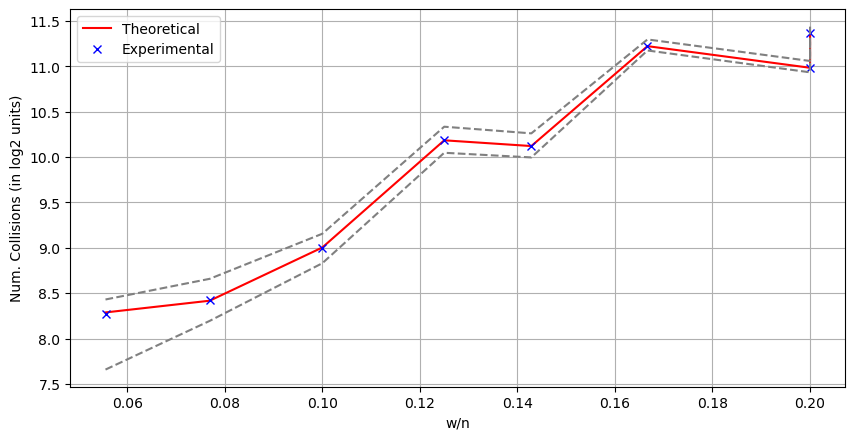

In [126]:
import matplotlib.pyplot as plt

g = plt.figure(figsize=(10, 5), dpi=100)
g = plt.plot([a[0] for a in th_vals],[a[1] for a in th_vals], 'r')
g = plt.plot([a[0] for a in emp_vals],[a[1] for a in emp_vals], 'bx')
g = plt.plot([a[0] for a in emp_min_vals],[a[1] for a in emp_min_vals], 'gray', linestyle = 'dashed')
g = plt.plot([a[0] for a in emp_max_vals],[a[1] for a in emp_max_vals], 'gray', linestyle = 'dashed')

g = plt.legend(['Theoretical', 'Experimental'])
g = plt.grid()
g = plt.xlabel('w/n')
g = plt.ylabel('Num. Collisions (in log2 units)')